In [1]:
import pandas as pd
from database.adatabase import ADatabase
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from processor.processor import Processor as p
from asset.exposure import Exposure
from equations.capm import CAPM
from sklearn.preprocessing import normalize
import yfinance as yf
from datetime import datetime, timedelta
from dotenv import load_dotenv
load_dotenv()
import os
from time import sleep
import requests as r
import yfinance as yf
import numpy as np
import pandas_datareader.data as web

In [2]:
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [3]:
market.connect()
index = market.retrieve("index")
market.disconnect()
factors = ["assets","liabilities","reference_price"]
fred.connect()
sp500 = p.column_date_processing(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
interest_rates = p.column_date_processing(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect
macro = sp500.merge(interest_rates,on="date",how="left")

In [4]:
index

,ticker,name,market,locale,primary_exchange,type,active,currency_name,cik,composite_figi,share_class_figi,last_updated_utc
0,A,Agilent Technologies Inc.,stocks,us,XNYS,CS,True,usd,0001090872,BBG000C2V3D6,BBG001SCTQY4,2025-02-27T00:00:00Z
1,AA,Alcoa Corporation,stocks,us,XNYS,CS,True,usd,0001675149,BBG00B3T3HD3,BBG00B3T3HF1,2025-03-21T00:00:00Z
2,AACT,Ares Acquisition Corporation II,stocks,us,XNYS,CS,True,usd,0001853138,NaN,NaN,2025-03-21T00:00:00Z
3,AAL,American Airlines Group Inc.,stocks,us,XNAS,CS,True,usd,0000006201,BBG005P7Q881,BBG005P7Q907,2024-05-17T00:00:00Z
4,AAM,AA Mission Acquisition Corp.,stocks,us,XNYS,CS,True,usd,0002012964,NaN,NaN,2025-03-21T00:00:00Z
...,...,...,...,...,...,...,...,...,...,...,...,...
5116,ZVSA,"ZyVersa Therapeutics, Inc. Common Stock",stocks,us,XNAS,CS,True,usd,0001859007,BBG01137LPK6,BBG01137LQD2,2025-03-21T00:00:00Z
5117,ZWS,Zurn Elkay Water Solutions Corporation,stocks,us,XNYS,CS,True,usd,0001439288,BBG000H8R0N8,BBG001T36GB5,2025-03-21T00:00:00Z
5118,ZYBT,Zhengye Biotechnology Holding Limited Ordinary...,stocks,us,XNAS,CS,True,usd,0001975641,NaN,NaN,2025-03-21T00:00:00Z
5119,ZYME,Zymeworks Inc.,stocks,us,XNAS,CS,True,usd,0001937653,BBG019XSYC89,BBG019XSYC98,2025-03-21T00:00:00Z


In [24]:
market.connect()
sec.connect()
factors_df = []
for row in tqdm(index.iterrows()):
    try:
        ticker = row[1]["ticker"]
        cik = int(row[1]["cik"])
        price = market.query("prices",{"ticker":ticker})
        filings = sec.query("filings",{"cik":cik})
        if price.index.size > 0 and filings.index.size > 0:
            price = p.column_date_processing(price)
            price.sort_values("date",inplace=True)
            price["year"] = [x.year for x in price["date"]]
            price["quarter"] = [x.quarter for x in price["date"]]
            filings = p.column_date_processing(filings).dropna()
            filings["year"] = [x.year + 1 for x in filings["date"]]
            filings["quarter"] = [x.quarter for x in filings["date"]]
            # filings["year"] = [x.year if x.quarter < 4 else x.year + 1 for x in filings["date"]]
            # filings["quarter"] = [x.quarter + 1 if x.quarter < 4 else 1 for x in filings["date"]]
            ticker_factors = filings.drop(["date","cik"],axis=1).groupby(["year","quarter"]).mean().reset_index()
            price = price.drop(["date","ticker"],axis=1).groupby(["year","quarter"]).mean().reset_index()
            ticker_factors = ticker_factors.merge(price,on=["year","quarter"],how="left")
            if ticker_factors.index.size > 0:
                ticker_factors["ticker"] = ticker
                ticker_factors["reference_price"] = ticker_factors["adjclose"].shift(1)
                ticker_factors["y"] = ticker_factors["adjclose"].shift(-1)
                factors_df.append(ticker_factors[["year","quarter","ticker","adjclose","y"]+factors])
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()
factors_df = pd.concat(factors_df).sort_values(["year","quarter"])

19it [00:00, 22.82it/s]

ABC cannot convert float NaN to integer


47it [00:02, 26.90it/s]

ACCS cannot convert float NaN to integer


94it [00:04, 20.93it/s]

ADS cannot convert float NaN to integer


156it [00:07, 24.96it/s]

AHS cannot convert float NaN to integer
AIFE cannot convert float NaN to integer


300it [00:14, 25.66it/s]

ANTM cannot convert float NaN to integer


847it [00:41, 23.96it/s]

CBG cannot convert float NaN to integer


921it [00:45, 18.80it/s]

CFI cannot convert float NaN to integer


1438it [01:11, 20.59it/s]

DVLT cannot convert float NaN to integer


1530it [01:16, 24.48it/s]

ELY cannot convert float NaN to integer


1652it [01:22, 21.27it/s]

EXOZ cannot convert float NaN to integer


1679it [01:24, 24.60it/s]

FBHS cannot convert float NaN to integer


1817it [01:31, 21.83it/s]

FRBA cannot convert float NaN to integer


2117it [01:47, 19.81it/s]

HCN cannot convert float NaN to integer


2213it [01:53, 22.00it/s]

HSC cannot convert float NaN to integer


2372it [02:01, 20.57it/s]

INT cannot convert float NaN to integer


3050it [02:38, 20.73it/s]

MSG cannot convert float NaN to integer


3082it [02:40, 22.12it/s]

MTVA cannot convert float NaN to integer


3145it [02:43, 26.03it/s]

NCR cannot convert float NaN to integer


3609it [03:09, 17.55it/s]

PKI cannot convert float NaN to integer


3794it [03:19, 24.19it/s]

QVCGA cannot convert float NaN to integer
QVCGB cannot convert float NaN to integer


4180it [03:41, 21.11it/s]

SLF cannot convert float NaN to integer


4232it [03:44, 25.12it/s]

SNE cannot convert float NaN to integer


4317it [03:48, 17.82it/s]

SSBI cannot convert float NaN to integer


4443it [03:55, 26.13it/s]

TBI cannot convert float NaN to integer


4452it [03:56, 20.44it/s]

TCK cannot convert float NaN to integer


4567it [04:03, 27.78it/s]

TOWN cannot convert float NaN to integer


4787it [04:16, 24.27it/s]

VEC cannot convert float NaN to integer


5121it [04:35, 18.60it/s]


In [26]:
model_start = 2015
model_end = 2022
backtest_end = 2026
model = XGBRegressor(booster="gbtree",random_state=42)
factors_df = factors_df.dropna(subset=factors)
training_data = factors_df[(factors_df["year"]>=model_start) & (factors_df["year"]<model_end)].dropna()
sim = factors_df[(factors_df["year"]>=model_end-1) & (factors_df["year"]<backtest_end)].dropna(subset=factors)
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])
sim = sim[["year","quarter","ticker","prediction"]]

In [27]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left").merge(macro,on="date",how="left")
        price["factor"] = price["prediction"] / price["adjclose"] - 1
        price = CAPM.apply(price)
        prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

  0%|▎                                                                                                                                                       | 12/5121 [00:00<05:52, 14.49it/s]

'date'


  0%|▌                                                                                                                                                       | 19/5121 [00:01<05:37, 15.10it/s]

'date'


  1%|█▏                                                                                                                                                      | 38/5121 [00:02<04:11, 20.18it/s]

'date'


  2%|██▊                                                                                                                                                     | 94/5121 [00:06<04:59, 16.76it/s]

'date'


  3%|████▏                                                                                                                                                  | 143/5121 [00:09<04:37, 17.94it/s]

'date'


  6%|████████▊                                                                                                                                              | 298/5121 [00:19<04:26, 18.07it/s]

'date'


 11%|█████████████████▏                                                                                                                                     | 583/5121 [00:38<03:34, 21.18it/s]

'date'
'date'


 12%|█████████████████▊                                                                                                                                     | 603/5121 [00:40<05:18, 14.18it/s]

'date'


 12%|██████████████████▎                                                                                                                                    | 623/5121 [00:41<03:55, 19.07it/s]

'date'


 14%|█████████████████████▎                                                                                                                                 | 722/5121 [00:47<03:36, 20.28it/s]

'date'
'date'


 17%|██████████████████████████▎                                                                                                                            | 894/5121 [00:59<03:58, 17.70it/s]

'date'


 20%|█████████████████████████████▍                                                                                                                        | 1005/5121 [01:07<04:10, 16.42it/s]

'date'


 21%|███████████████████████████████▉                                                                                                                      | 1091/5121 [01:13<04:21, 15.43it/s]

'date'


 22%|█████████████████████████████████▌                                                                                                                    | 1147/5121 [01:17<03:09, 20.98it/s]

'date'
'date'


 25%|████████████████████████████████████▉                                                                                                                 | 1260/5121 [01:25<04:00, 16.03it/s]

'date'


 30%|████████████████████████████████████████████▊                                                                                                         | 1531/5121 [01:46<03:46, 15.87it/s]

'date'


 33%|█████████████████████████████████████████████████▏                                                                                                    | 1680/5121 [01:56<03:17, 17.45it/s]

'date'


 38%|████████████████████████████████████████████████████████▍                                                                                             | 1926/5121 [02:14<02:38, 20.20it/s]

'date'


 41%|████████████████████████████████████████████████████████████▊                                                                                         | 2075/5121 [02:24<03:07, 16.28it/s]

'date'


 42%|██████████████████████████████████████████████████████████████▎                                                                                       | 2128/5121 [02:28<03:57, 12.58it/s]

'date'


 43%|████████████████████████████████████████████████████████████████▊                                                                                     | 2213/5121 [02:34<02:25, 20.05it/s]

'date'


 44%|█████████████████████████████████████████████████████████████████▉                                                                                    | 2250/5121 [02:36<03:10, 15.04it/s]

'date'


 46%|█████████████████████████████████████████████████████████████████████▌                                                                                | 2375/5121 [02:44<02:29, 18.42it/s]

'date'


 52%|██████████████████████████████████████████████████████████████████████████████                                                                        | 2667/5121 [03:03<02:52, 14.26it/s]

'date'


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                       | 2682/5121 [03:04<01:44, 23.32it/s]

'date'
'date'


 58%|██████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2952/5121 [03:21<01:49, 19.72it/s]

'date'


 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                              | 3003/5121 [03:25<01:51, 18.97it/s]

'date'
'date'
'date'


 60%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 3049/5121 [03:28<01:52, 18.45it/s]

'date'


 61%|████████████████████████████████████████████████████████████████████████████████████████████                                                          | 3145/5121 [03:35<01:36, 20.46it/s]

'date'


 62%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 3163/5121 [03:36<02:14, 14.52it/s]

'date'


 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 3253/5121 [03:43<02:02, 15.21it/s]

'date'


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3570/5121 [04:06<02:10, 11.93it/s]

'date'


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3610/5121 [04:08<01:38, 15.34it/s]

'date'


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4296/5121 [04:55<00:50, 16.26it/s]

'date'


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 4429/5121 [05:05<00:38, 17.85it/s]

'date'


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4453/5121 [05:06<00:36, 18.41it/s]

'date'


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 4563/5121 [05:14<00:25, 21.83it/s]

'date'


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4696/5121 [05:23<00:27, 15.40it/s]

'date'


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 4783/5121 [05:30<00:18, 18.51it/s]

'date'


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4996/5121 [05:44<00:08, 14.16it/s]

'date'


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5121/5121 [05:51<00:00, 14.56it/s]


In [111]:
simulation = pd.concat(prices).merge(index,on="ticker",how="left")
#.merge(market_caps_df,on="ticker",how="left")
simulation["year"] = simulation["date"].dt.year
simulation["quarter"] = simulation["date"].dt.quarter
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)].dropna()
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]
simulation["market_cap"] = simulation["adjclose"] * simulation["adjvolume"]
simulation["market_cap_rank"] = simulation.groupby(["year","quarter"])["market_cap"].rank(ascending=False,pct=True)
simulation["market_cap_rank"] = [round(x*100/10) for x in simulation["market_cap_rank"]]
simulation["rank"] = simulation.groupby(["date", "market_cap_rank"])["factor"].rank(method="dense", ascending=False).astype(int)

# Calculate the total number of ranks for each sector and date
simulation["total_ranks"] = simulation.groupby(["date", "market_cap_rank"])["rank"].transform("max")

# Assign exposure based on rank
simulation["exposure"] = simulation.apply(
    lambda x: 1 if x["rank"] <= x["total_ranks"] * 0.50 else -1,
    axis=1
)

# Cleanup: Drop the total_ranks column if not needed
simulation.drop(columns=["total_ranks"], inplace=True)

# Sorting by date for further processing
simulation.sort_values("date", inplace=True)
simulation["sell_price"] = simulation["adjclose"]
simulation["sell_date"] = simulation["date"]
simulation.sort_values("date",inplace=True)

In [112]:
benchmark = macro.copy()
benchmark["year"] = benchmark["date"].dt.year
benchmark["quarter"] = benchmark["date"].dt.quarter
benchmark = benchmark[(benchmark["year"]>=model_end) & (benchmark["year"]<backtest_end)].drop([x for x in benchmark.columns if "real" in x],axis=1).groupby(["year","quarter"]).mean().reset_index()
benchmark["sp500"] = (benchmark["sp500"] - benchmark["sp500"].iloc[0]) /benchmark["sp500"].iloc[0]
benchmark["rf"] = (benchmark["rf"] - benchmark["rf"].iloc[0]) /benchmark["rf"].iloc[0]
benchmark["sp500_prediction"] = (benchmark["sp500_prediction"] - benchmark["sp500_prediction"].iloc[0]) /benchmark["sp500_prediction"].iloc[0]
benchmark.dropna(inplace=True)

In [113]:
def rank_list(value,i):
    # Ensure i is a non-negative integer
    if value == 0:
        if i < 0:
            raise ValueError("The number of integers, i, must be non-negative.")
        
        if i % 2 == 0:
            # Even number of elements: Symmetric around 0
            return list(range(-i // 2, i // 2))
        else:
            # Odd number of elements: Includes 0
            return list(range(-i // 2, i // 2 + 1))
    if value == -1:
        return list(range(-1,-i-1,-1))
    else:
        return list(range(0,i,1))

In [114]:
filtered_columns = ["year","quarter","date","sell_date","market_cap_rank","ticker","rank","exposure","adjclose","sell_price"]
agg_query = {"date":"first","sell_date":"last","market_cap_rank":"first","exposure":"first","rank":"first","adjclose":"first","sell_price":"last"}

In [172]:
run = True
num_tickers = len(list(simulation["ticker"].unique()))
stock_steps = 0.01
stock_cap = 0.1
num_stocks = [i for i in range(0,int(num_tickers*stock_cap),int(num_tickers*stock_steps)) if i != 0]
num_stocks.append(1)
index_steps = 1
analysises = []
market_cap_maxes = [i for i in range(0,10,index_steps) if i != 0]
for direction in tqdm([1,-1]):
    for value in [1,0,-1]:
        for maximum_index in market_cap_maxes:
            minimum_indexes = [i for i in range(0,maximum_index,index_steps)]
            for minimum_index in minimum_indexes:
                for num_stocks_per_industry in num_stocks:
                    try:
                        parameters = {
                            "direction":direction,
                            "val":value,
                            "mini": minimum_index,
                            "maxi": maximum_index,
                            "stacks": num_stocks_per_industry
                        }
                        stacks = rank_list(value,num_stocks_per_industry)
                        filtered_simulation = simulation[(simulation["market_cap_rank"]<=maximum_index) & (simulation["market_cap_rank"]>=minimum_index)].copy()
                        trades = filtered_simulation[filtered_columns].groupby(["year","quarter","ticker"]).agg(agg_query).copy().reset_index()
                        trades = trades.sort_values("rank",ascending=True).groupby(["year","quarter","market_cap_rank"]).nth(stacks).reset_index()
                        trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
                        trades["return"] = trades["return"] * trades["exposure"] * direction
                        analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()
                        portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).mean().reset_index().sort_values(["year","quarter"])
                        portfolio["return"] = portfolio["return"] + 1
                        portfolio["return"] = portfolio["return"].cumprod() - 1
                        portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
                        portfolio = portfolio.merge(benchmark,on=["year","quarter"],how="left")
                        portfolio["sharpe"] = portfolio["return"] - portfolio["rf"] / portfolio["return"].std()
                        parameters["risk"] = portfolio["return"].std()
                        parameters["sharpe"] = portfolio["sharpe"].iloc[-1]
                        parameters["return"] = portfolio["return"].iloc[-1]
                        analysises.append(parameters)
                    except Exception as e:
                        print(str(e))
                        continue

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [1:05:01<00:00, 1950.72s/it]


In [173]:
a = pd.DataFrame(analysises)
a["color"] = ["blue" if x == 1 else "red" if x == -1  else "green" for x in a["val"]]
a["return_to_risk"] = a["return"] / a["risk"]

In [175]:
a.sort_values("return",ascending=False).head(20)

,direction,val,mini,maxi,stacks,risk,sharpe,return,color,return_to_risk
2848,-1,-1,5,8,1,4.006594,7.319660,7.641753,red,1.907294
43,1,1,0,3,1,2.207723,6.738000,7.322538,blue,3.316783
2276,-1,0,5,7,1,2.172595,5.730949,6.324938,green,2.911237
219,1,1,4,6,1,2.807948,5.549026,6.008613,blue,2.139859
1781,-1,1,5,7,1,1.456154,4.480558,5.366795,blue,3.685596
120,1,1,0,5,1,1.574758,3.013267,3.832756,blue,2.433870
2342,-1,0,4,8,1,1.202899,2.674641,3.747464,green,3.115362
714,1,0,4,6,1,1.570375,2.729294,3.551071,green,2.261289
2837,-1,-1,4,8,1,2.007813,2.841503,3.484241,red,1.735342
21,1,1,0,2,1,1.215161,2.321769,3.383767,blue,2.784625


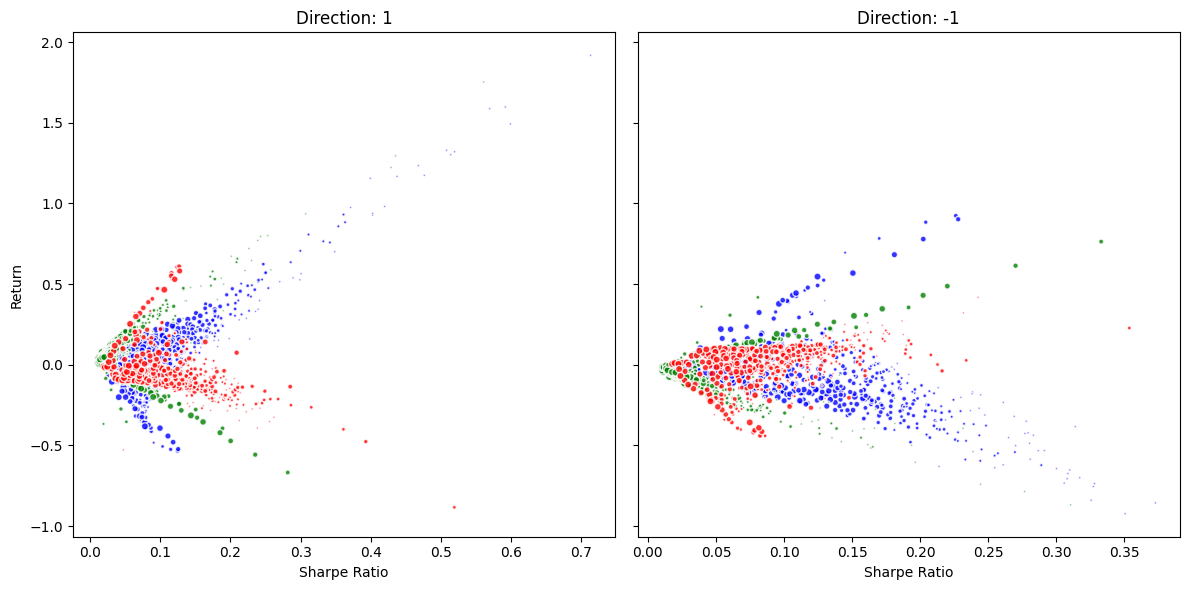

In [196]:
view = a[a["stacks"]>1]
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Direction: 1", "Direction: -1"]

# Iterate over directions and corresponding axes
for i, direction in enumerate([1, -1]):
    d_analysis = view[view["direction"] == direction]
    axes[i].scatter(
        d_analysis["risk"],
        d_analysis["return"],
        c=d_analysis["color"],
        s=d_analysis["stacks"]/10,
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Sharpe Ratio")
    axes[i].set_ylabel("Return" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [231]:
top = a[a["direction"]==1].sort_values("return",ascending=False).iloc[0]
print(top)
direction = top["direction"].item()
value = top["val"].item()
maximum_index = top["maxi"].item()
minimum_index = top["mini"].item()
num_stocks_per_industry = top["stacks"].item()
stacks = rank_list(value,num_stocks_per_industry)

direction                1
val                      1
mini                     0
maxi                     3
stacks                   1
risk              2.207723
sharpe               6.738
return            7.322538
color                 blue
return_to_risk    3.316783
Name: 43, dtype: object


In [232]:
stacks = rank_list(value,num_stocks_per_industry)
filtered_simulation = simulation[(simulation["market_cap_rank"]<=maximum_index) & (simulation["market_cap_rank"]>=minimum_index)].copy()
trades = filtered_simulation[filtered_columns].groupby(["year","quarter","ticker"]).agg(agg_query).copy().reset_index()
trades = trades.sort_values("rank",ascending=True).groupby(["year","quarter","market_cap_rank"]).nth(stacks).reset_index()
trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
trades["return"] = trades["return"] * trades["exposure"] * direction 
trades = trades.merge(index[["ticker","name"]],on="ticker",how="left")
trades["count"] = 1
analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()
portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).mean().reset_index().sort_values(["year","quarter"])
portfolio["return"] = portfolio["return"] + 1
portfolio["return"] = portfolio["return"].cumprod() - 1
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
portfolio = portfolio.merge(benchmark,on=["year","quarter"],how="left")

In [233]:
trades.groupby(["name","ticker"]).agg({"return":"mean","count":"sum","adjclose":"mean"}).sort_values("return",ascending=False).head(40)

,,return,count,adjclose
name,ticker,,,
"CommScope Holding Company, Inc.",COMM,2.491429,1,1.750000
Archer Aviation Inc.,ACHR,2.282828,1,2.970000
"Firefly Neuroscience, Inc. Common Stock",AIFF,1.473016,1,3.150000
"C4 Therapeutics, Inc.",CCCC,1.414530,1,2.340000
"Neuronetics, Inc. Common Stock",STIM,1.162393,1,2.340000
"National CineMedia, Inc.",NCMI,1.076177,1,2.061000
TeraWulf Inc. Common Stock,WULF,0.915638,2,1.815000
Carvana Co.,CVNA,0.859155,2,15.580000
"Banzai International, Inc. Class A Common Stock",BNZI,0.448155,1,5.690000


In [242]:
trades.sort_values("date",ascending=True).head(20)

,index,year,quarter,ticker,date,sell_date,market_cap_rank,exposure,rank,adjclose,sell_price,return,name,count
47,987,2022,1,RIOT,2022-01-03,2022-03-31,1,1,1,22.74,21.17,-0.069041,"Riot Platforms, Inc. Common Stock",1
30,581,2022,1,IMUX,2022-01-04,2022-02-01,3,1,1,10.31,13.96,0.354025,"Immunic, Inc. Common Stock",1
46,730,2022,1,MGLD,2022-03-11,2022-03-14,0,1,1,4.11,3.39,-0.175182,"The Marygold Companies, Inc.",1
42,860,2022,1,ORIC,2022-03-22,2022-03-22,2,1,1,4.76,4.76,0.000000,"Oric Pharmaceuticals, Inc. Common Stock",1
36,2067,2022,2,MARA,2022-04-01,2022-06-30,1,1,1,28.54,5.34,-0.812894,"MARA Holdings, Inc. Common Stock",1
49,2374,2022,2,RH,2022-04-01,2022-06-30,0,1,1,320.54,212.26,-0.337805,RH,1
33,2004,2022,2,KOD,2022-06-01,2022-06-01,3,1,1,7.53,7.53,0.000000,Kodiak Sciences Inc Common Stock,1
7,1958,2022,2,IPM,2022-06-10,2022-06-10,2,1,1,2.23,2.23,0.000000,Intelligent Protection Management Corp. Common...,1
5,3054,2022,3,CVNA,2022-07-01,2022-09-30,0,1,1,21.87,20.30,-0.071788,Carvana Co.,1
41,3487,2022,3,MARA,2022-07-01,2022-09-30,2,1,1,5.54,10.71,0.933213,"MARA Holdings, Inc. Common Stock",1


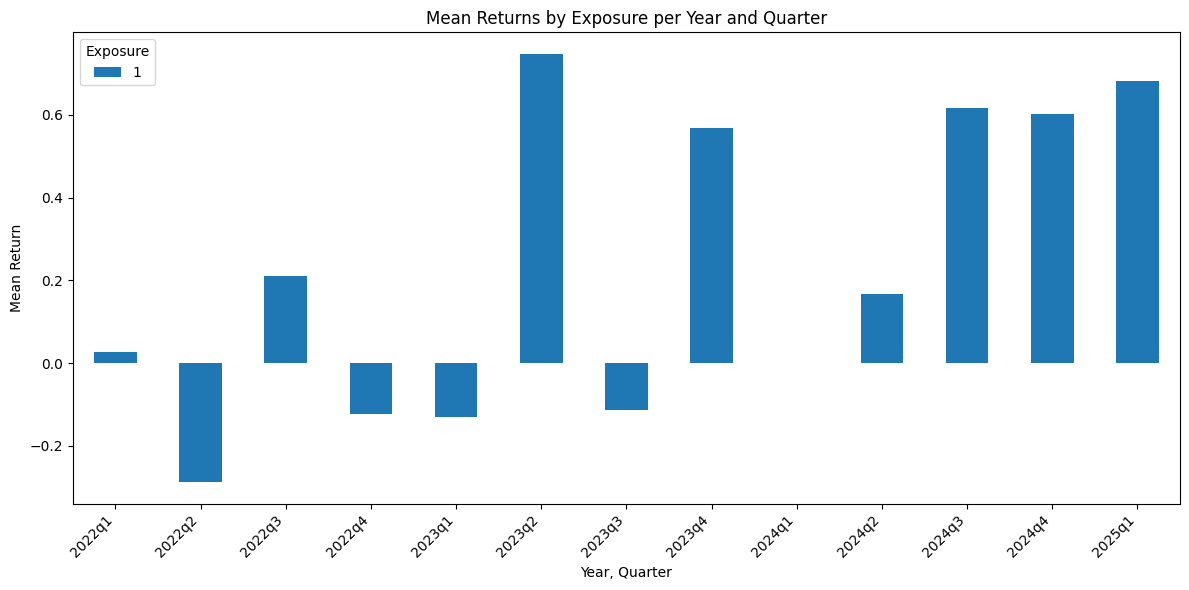

In [235]:
analysis['Year-Quarter'] = analysis["year"].astype(str) + "q" + analysis["quarter"].astype(str)

# Reset index for plotting
analysis.drop(["year","quarter"],axis=1,inplace=True)
analysis.reset_index(drop=True, inplace=True)

# Plot a bar chart
analysis.set_index("Year-Quarter").plot(
    kind="bar",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Customize the plot
plt.xlabel("Year, Quarter")
plt.ylabel("Mean Return")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title="Exposure")
plt.tight_layout()

# Show the plot
plt.show()


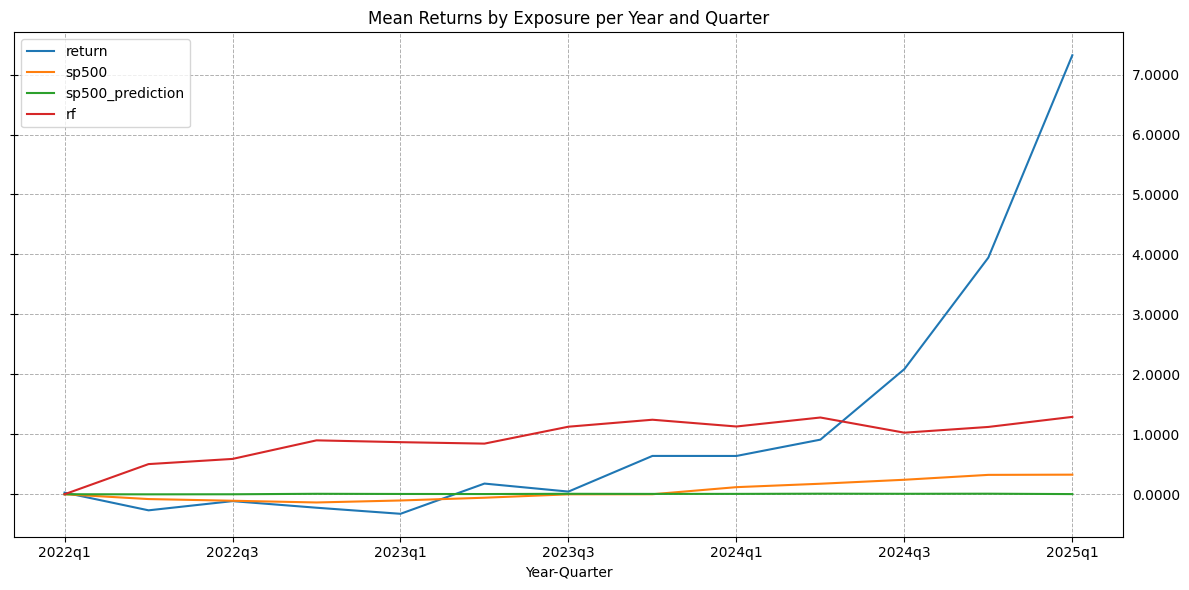

In [236]:
# Create the plot
ax = portfolio.drop(["date", "year", "quarter"], axis=1).set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()


In [243]:
portfolio.head()

,year,quarter,return,Year-Quarter,date,sp500,sp500_prediction,rf
0,2022,1,0.027450,2022q1,2022-02-15 16:38:42.580645120,0.000000,0.000000,0.000000
1,2022,2,-0.268121,2022q2,2022-05-16 08:07:44.516129024,-0.080242,-0.001327,0.503017
2,2022,3,-0.114714,2022q3,2022-08-16 15:45:00.000000000,-0.108315,-0.000272,0.589384
3,2022,4,-0.224674,2022q4,2022-11-15 05:42:51.428571392,-0.137075,0.007780,0.899023
4,2023,1,-0.325961,2023q1,2023-02-16 02:42:34.838709760,-0.103899,0.004773,0.868810


In [241]:
trades.groupby(["year","quarter","market_cap_rank"]).agg({"return":"mean"})

return
year quarter market_cap_rank          
2022 1       0               -0.175182
             1               -0.069041
             2                0.000000
             3                0.354025
     2       0               -0.337805
             1               -0.812894
             2                0.000000
             3                0.000000
     3       0               -0.071788
             1               -0.022997
             2                0.933213
             3                0.000000
     4       0               -0.253112
             1               -0.243722
             2                0.000000
             3                0.000000
2023 1       0               -0.037767
             1                0.121622
             2               -0.591602
             3               -0.014803
     2       0                0.124823
             1                1.790097
             2                0.000000
             3                1.076177
     3       0               -0.456250
             1               -0.005998
             2                0.000000
             3                0.008969
     4       0                1.414530
             1               -0.136842
             2                0.000000
             3                1.000000
2024 1       0               -0.065287
             1                0.063811
             2                0.000000
             3                0.000000
     2       0               -0.071767
             1                0.278970
             2                0.831276
             3               -0.374233
     3       0                0.448155
             1                0.000000
             2                2.491429
             3               -0.476744
     4       0                0.126791
             1                0.000000
             2                2.282828
             3                0.000000
2025 1       0                0.093458
             1                1.473016
             2                0.000000
             3                1.162393

In [239]:
simulation[simulation["date"]==simulation["date"].max()].sort_values("rank",ascending=True).head(20)[["market_cap_rank","ticker","rank"]]

,market_cap_rank,ticker,rank
355828,7,AEON,1
8081957,1,LCID,1
2868563,6,CHRS,1
13795159,5,TLRY,1
10412564,2,OPEN,1
11399736,0,PSTV,1
5905583,4,GCTK,1
14911735,9,VYNE,1
5032571,10,EVTV,1
3826143,8,CVM,1


In [240]:
simulation.groupby("ticker").agg({"market_cap":"mean"}).sort_values("market_cap",ascending=False).head(20)

,market_cap
ticker,
TSLA,2.475185e+10
NVDA,2.267234e+10
AAPL,1.173512e+10
MSFT,8.499891e+09
META,6.751847e+09
GOOGL,4.176898e+09
GOOG,3.189125e+09
NFLX,2.688189e+09
SMCI,2.052979e+09


In [227]:
print(((macro["sp500"].pct_change().cumsum().iloc[-1]+1) ** (1/6))/macro["sp500"].pct_change().cumsum().std())

4.289717553646794
